In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import pickle as pkl
import numpy as np

# Pre-Processing and Transformation

In [5]:
with open('mar.txt','r') as f:
  data = f.read()

In [6]:
uncleaned_data_list = data.split('\n')
len(uncleaned_data_list)
uncleaned_data_list = uncleaned_data_list[:38695]
len(uncleaned_data_list)
english_word = []
marathi_word = []
cleaned_data_list = []
for word in uncleaned_data_list:
  english_word.append(word.split('\t')[:-1][0])
  marathi_word.append(word.split('\t')[:-1][1])
language_data = pd.DataFrame(columns=['English','Marathi'])
language_data['English'] = english_word
language_data['Marathi'] = marathi_word
language_data.to_csv('language_data.csv', index=False)

In [7]:
english_text = language_data['English'].values
marathi_text = language_data['Marathi'].values
len(english_text), len(marathi_text)

(7507, 7507)

Data Cleaning

In [8]:
#to lower case
english_text_ = [x.lower() for x in english_text]
marathi_text_ = [x.lower() for x in marathi_text]
#removing inverted commas
english_text_ = [re.sub("'",'',x) for x in english_text_]
marathi_text_ = [re.sub("'",'',x) for x in marathi_text_]
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text
english_text_ = remove_punc(english_text_)
marathi_text_ = remove_punc(marathi_text_)
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in english_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
english_text_ = removed_digits_text
# removing the digits from the marathi sentances
marathi_text_ = [re.sub("[२३०८१५७९४६]","",x) for x in marathi_text_]
marathi_text_ = [re.sub("[\u200d]","",x) for x in marathi_text_]
# removing the stating and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
marathi_text_ = [x.strip() for x in marathi_text_]

Adding ‘start’ and ‘end’ tag to marathi sentence.

In [9]:
# Putting the start and end words in the marathi sentances
marathi_text_ = ["start " + x + " end" for x in marathi_text_]
# manipulated_marathi_text_
marathi_text_[0], english_text_[0]

('start जा end', 'go')

# Data Preparation for Model Building

In [10]:
X = english_text_
Y = marathi_text_
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.1)

determine the maximum length of our sentences in both English and Marathi

In [11]:
def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_
#Training data
max_length_english = Max_length(X_train)
max_length_marathi = Max_length(y_train)
#Test data
max_length_english_test = Max_length(X_test)
max_length_marathi_test = Max_length(y_test)
max_length_marathi, max_length_english

(9, 5)

# Tokenization

In [12]:
# convert string input to a numerical list
# using Tokenizer in the keras-preprocessing library.
"""
it is mandatory to have an equal length of all input sequences in sequence-to-sequence models.
So, we will pad extra ‘0s’ to make the sequence of the same length. This would be done by pad_sequence
"""

englishTokenizer = Tokenizer()
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1
X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')
X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_english, padding='post')
marathiTokenizer = Tokenizer()
marathiTokenizer.fit_on_texts(y_train)
Mword2index = marathiTokenizer.word_index
vocab_size_target = len(Mword2index) + 1
y_train = marathiTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_marathi, padding='post')
y_test = marathiTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_marathi, padding='post')
vocab_size_source, vocab_size_target

(1565, 2916)

In [13]:
X_train[0], y_train[0]

(array([ 19,   4, 190,   0,   0], dtype=int32),
 array([  1, 158,  25,   7,   2,   0,   0,   0,   0], dtype=int32))

To save our preprocessing time whenever we reuse it again in future, we will save our important attributes

In [14]:
with open('NMT_data.pkl','wb') as f:
  pkl.dump([X_train, y_train, X_test, y_test],f)
with open('NMT_Etokenizer.pkl','wb') as f:
  pkl.dump([vocab_size_source, Eword2index, englishTokenizer], f)
with open('NMT_Mtokenizer.pkl', 'wb') as f:
  pkl.dump([vocab_size_target, Mword2index, marathiTokenizer], f)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

Keras does not officially support attention layer. we can either implement our own attention layer or use a third-party implementation.

In [15]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [18]:
!pip install pydot

In [21]:
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 697.5 kB/s eta 0:00:00


In [22]:
import pydot
import graphviz
K.clear_session()
latent_dim = 500
# Encoder
encoder_inputs = Input(shape=(max_length_english,))
enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs)
#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
#LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
#LSTM 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
#Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
#Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
plot_model(model, to_file='train_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model Training

In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [25]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:],
                    epochs=50,
                    callbacks=[es],
                    batch_size=512,
                    validation_data = ([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/50
14/14 [==============================] - 16s 622ms/step - loss: 6.0327 - accuracy: 0.4404 - val_loss: 3.1665 - val_accuracy: 0.5005
Epoch 2/50
14/14 [==============================] - 7s 492ms/step - loss: 3.1779 - accuracy: 0.4930 - val_loss: 2.8718 - val_accuracy: 0.5604
Epoch 3/50
14/14 [==============================] - 7s 497ms/step - loss: 2.9536 - accuracy: 0.5361 - val_loss: 2.6961 - val_accuracy: 0.5604
Epoch 4/50
14/14 [==============================] - 7s 496ms/step - loss: 2.8112 - accuracy: 0.5433 - val_loss: 2.6314 - val_accuracy: 0.5694
Epoch 5/50
14/14 [==============================] - 7s 494ms/step - loss: 2.7301 - accuracy: 0.5481 - val_loss: 2.5644 - val_accuracy: 0.5871
Epoch 6/50
14/14 [==============================] - 7s 486ms/step - loss: 2.6627 - accuracy: 0.5580 - val_loss: 2.5201 - val_accuracy: 0.5887
Epoch 7/50
14/14 [==============================] - 7s 497ms/step - loss: 2.5900 - accuracy: 0.5858 - val_loss: 2.4509 - val_accuracy: 0.6027
Epoch

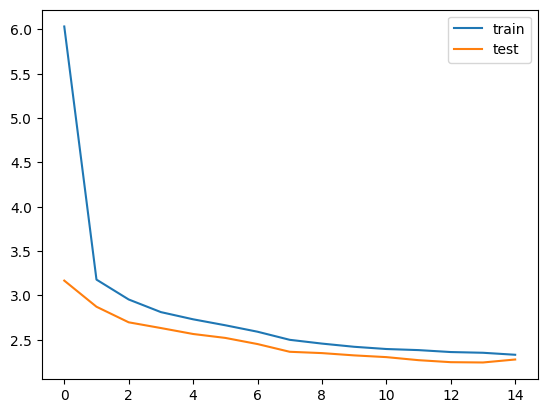

In [26]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Model Saving and Loading.
save the trained model with proper weights.

In [27]:
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")

Saved model to disk


Load model

In [28]:
# loading the model architecture and asigning the weights
json_file = open('NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# load weights into new model
model_loaded.load_weights("NMT_model_weight.h5")

Inference Model.
=> to predict our output sequences by considering weights from a pre-trained model.

In [29]:
latent_dim=500
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs
#print(encoder_outputs.shape)
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(32,latent_dim))
# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output
#print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

# Predcitions

In [53]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = Mword2index['start']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
            break
        else:
            sampled_token = Mindex2word[sampled_token_index]
            if sampled_token != 'end':
                decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
            if sampled_token == 'end' or len(decoded_sentence.split()) >= (26 - 1):
                stop_condition = True

            # Update the target sequence (of length 1).
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

            # Update internal states
            e_h, e_c = h, c

    return decoded_sentence


Forming a reverse vocabulary

In [33]:
Eindex2word = englishTokenizer.index_word
Mindex2word = marathiTokenizer.index_word

Some transformation before giving a string to the function

In [34]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=Mword2index['start']) and i!=Mword2index['end']):
        newString=newString+Mindex2word[i]+' '
    return newString
def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+Eindex2word[i]+' '
    return newString

Call the necessary functions to test the translation model

In [39]:
# Encoder
encoder_inputs = Input(shape=(max_length_english,))

# Decoder
decoder_inputs = Input(shape=(None,))
print(encoder_inputs)
print(decoder_inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name='input_14'), name='input_14', description="created by layer 'input_14'")
KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.float32, name='input_15'), name='input_15', description="created by layer 'input_15'")


In [40]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 5, 500)               782500    ['input_5[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 5, 500),             2002000   ['embedding[0][0]']           
                              (None, 500),                                                        
                              (None, 500)]                                                        
                                                                                              

In [55]:
# Define the maximum length expected by the model
max_length_english = 32  # Update this if your model expects a different length
max_length_marathi = 32  # Update this if your model expects a different length

# Padding training and test data
# X_train_padded = pad_sequences(X_train, maxlen=max_length_english, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length_english, padding='post')
y_train_padded = pad_sequences(y_train, maxlen=max_length_marathi, padding='post')
y_test_padded = pad_sequences(y_test, maxlen=max_length_marathi, padding='post')

# Adjust the loop for the test data
for i in range(10):
    print("Review:", seq2text(X_test_padded[i]))
    print("Original summary:", seq2summary(y_test[i]))
    print("Predicted summary:", decode_sequence(X_test_padded[i].reshape(1, max_length_english)))
    print("\n")

# max_length = 32
# X_test_padded = pad_sequences(X_test, maxlen = max_length, padding='post')
# for i in range(10):
#   print("Review:",seq2text(X_test_padded[i]))
#   print("Original summary:",seq2summary(y_test[i]))
#   print("Predicted summary:",decode_sequence(X_test_padded[i].reshape(1,max_length)))
#   print("\n")

Review: i read your book 
Original summary: मी तुमचं पुस्तक वाचलं 
1/1 [==============================] - 0s 28ms/step
Predicted summary:  मी मी मी मला मला आहे


Review: the food is cold 
Original summary: ते खाणं थंड आहे 
1/1 [==============================] - 0s 29ms/step
Predicted summary:  थांबलं मी मी मी मी मी मी मी मी मी मी मी मी मी मी मी मी मी मी मी मी मी मी मी मी


Review: i have a dog 
Original summary: माझ्याकडे कुत्रा आहे 
1/1 [==============================] - 0s 29ms/step
Predicted summary:  मी मी मी मला मला आहे


Review: copy this file 
Original summary: ही फाइल कॉपी करा 
1/1 [==============================] - 0s 29ms/step
Predicted summary:  मी मी मी मला मला आहे


Review: this is my book 
Original summary: हे माझं पुस्तक आहे 
1/1 [==============================] - 0s 29ms/step
Predicted summary:  मी मी मी मला मला आहे


Review: how is it 
Original summary: कसं आहे 
1/1 [==============================] - 0s 30ms/step
Predicted summary:  थांबलं थांबलं जराशी जराशी जराशी जराश